In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# Reading the data

df_checkin = pd.read_csv('restaurant_checkin.csv')
df_sub_cat = pd.read_excel('restaurant_sub_cat_sk.xlsx')
df_top_words = pd.read_excel('keyword_tfidf_sub_cat_sk.xlsx')

In [3]:
print(df_checkin.shape)
df_checkin.head()

(30023, 14)


Unnamed: 0             business_id                             name  \
0           0  vjTVxnsQEZ34XjYNS-XUpA                wetzel's pretzels   
1           1  fnZrZlqW1Z8iWgTVDfv_MA                        carl's jr   
2           2  rVBPQdeayMYht4Uv_FOLHg           gourmet burger company   
3           3  98hyK2QEUeI8v2y0AghfZA  pho lee's vietnamese restaurant   
4           4  fhNf_sg-XzZ3e7HEVGuOZg            meat chix and wieners   

                                          categories  \
0   food, pretzels, bakeries, fast food, restaurants   
1                    mexican, restaurants, fast food   
2                         restaurants, burgers, food   
3                      restaurants, vietnamese, soup   
4  burgers, restaurants, american (traditional), ...   

  attributes.RestaurantsPriceRange2  \
0                                 1   
1                                 1   
2                                 2   
3                               NaN   
4                                 2   

                                 attributes.Ambience  review_count  \
0  {'romantic': False, 'intimate': False, 'touris...            10   
1  {'romantic': False, 'intimate': False, 'classy...            15   
2  {'romantic': False, 'intimate': False, 'classy...            13   
3  {'touristy': False, 'hipster': False, 'romanti...            23   
4  {'romantic': False, 'intimate': False, 'touris...            10   

                        address postal_code       city state   longitude  \
0  4550 East Cactus Rd, #KSFC-4       85032    phoenix    AZ -111.983533   
1          9595 W Tropicana Ave       89147  las vegas    NV -115.301568   
2            843 Kipling Avenue     M8Z 5G9    toronto    ON  -79.531768   
3       1541 E 38th St, Ste 101       44114  cleveland    OH  -81.663332   
4           6530 S Decatur Blvd       89118  las vegas    NV -115.207463   

    latitude                                               date  
0  33.602822  2010-07-06 21:38:52, 2010-08-29 17:19:51, 2012...  
1  36.099738  2010-08-10 19:09:06, 2010-08-10 19:10:05, 2010...  
2  43.633291  2010-09-29 23:18:27, 2010-10-03 18:26:37, 2010...  
3  41.512155  2019-08-18 21:17:31, 2019-08-31 17:06:17, 2019...  
4  36.071196  2013-06-28 18:49:25, 2013-07-07 23:01:11, 2013...

In [4]:
print(df_sub_cat.shape)
df_sub_cat.head()

(22044, 15)


Unnamed: 0             business_id sub_category  category  \
0           0  5I8VE_KBcDhh6uzdt5hwTg          0_1         0   
1           1                     NaN          0_0         0   
2           2  -fVZrbmka-9Mq2TtCGHxxw          0_1         0   
3           3  CwtjAViLdvXurW67H-7G3Q          0_1         0   
4           4  K-iqIqMTTvESaAz2KgwulA          0_1         0   

                     name                                         categories  \
0              cake azure  food, nightlife, adult entertainment, bakeries...   
1  mg patisserie and cafe  bakeries, patisserie/cake shop, food, coffee &...   
2        cupcrazed cakery                           desserts, food, cupcakes   
3    priory fine pastries                       food, bakeries, custom cakes   
4     nothing bundt cakes                 cupcakes, desserts, bakeries, food   

  attributes.RestaurantsPriceRange2 attributes.Ambience  review_count  \
0                               NaN                 NaN            34   
1                               NaN                 NaN            47   
2                                 1                 NaN            65   
3                                 2                 NaN            48   
4                                 2                 NaN           368   

                        address postal_code        city state   longitude  \
0           9817 Ridge Creek Pl       89134   las vegas    NV -115.310131   
1  6365 S Rainbow Blvd, Ste 101       89118   las vegas    NV -115.242870   
2     1730 E Woodlawn Rd, Ste H       28209   charlotte    NC  -80.846997   
3                 528 E Ohio St       15212  pittsburgh    PA  -79.999754   
4    8320 W Sahara Ave, Ste 140       89117   las vegas    NV -115.272980   

    latitude  
0  36.192429  
1  36.072427  
2  35.171736  
3  40.453851  
4  36.144698

In [5]:
df_sub_cat['sub_category'].nunique()

63

In [6]:
# Filtering out the null business ids

df_sub_cat = df_sub_cat[df_sub_cat['business_id'].notna()]

In [7]:
# Merging sub categories with restaurant checkin

df_rest = pd.merge(df_checkin, df_sub_cat[['business_id', 'sub_category', 'category']], on='business_id', how='left')
df_rest.shape

(30023, 16)

In [8]:
# Split a single value in to multiple rows

df_rest = df_rest.rename(columns={'Unnamed: 0': 'row_id'})

df_exp = pd.concat([pd.Series(row['row_id'],  str(row['date']).split(',')) for _, row in df_rest.iterrows()]).reset_index()

df_exp = df_exp.rename(columns={0:'row_id', 'index': 'date_2'})

df_rest = pd.merge(df_rest, df_exp, on='row_id', how='left')
df_rest.shape

(7923948, 17)

In [9]:
# Getting hour from date time

df_rest['date_2'] = pd.to_datetime(df_rest['date_2'])

df_rest['hour'] = df_rest['date_2'].apply(lambda x: x.hour)

In [10]:
# Grouping the data and calculating the min max normalization

df_group = df_rest.groupby(['category', 'sub_category', 'city', 'hour']).agg({'row_id': 'count'}).reset_index()

df_group = df_group.rename(columns={'row_id': 'count'})

df_group['score'] = df_group.groupby(['category', 'city'])['count'].transform(lambda x: (x - x.min()) / (x.max()- x.min()))

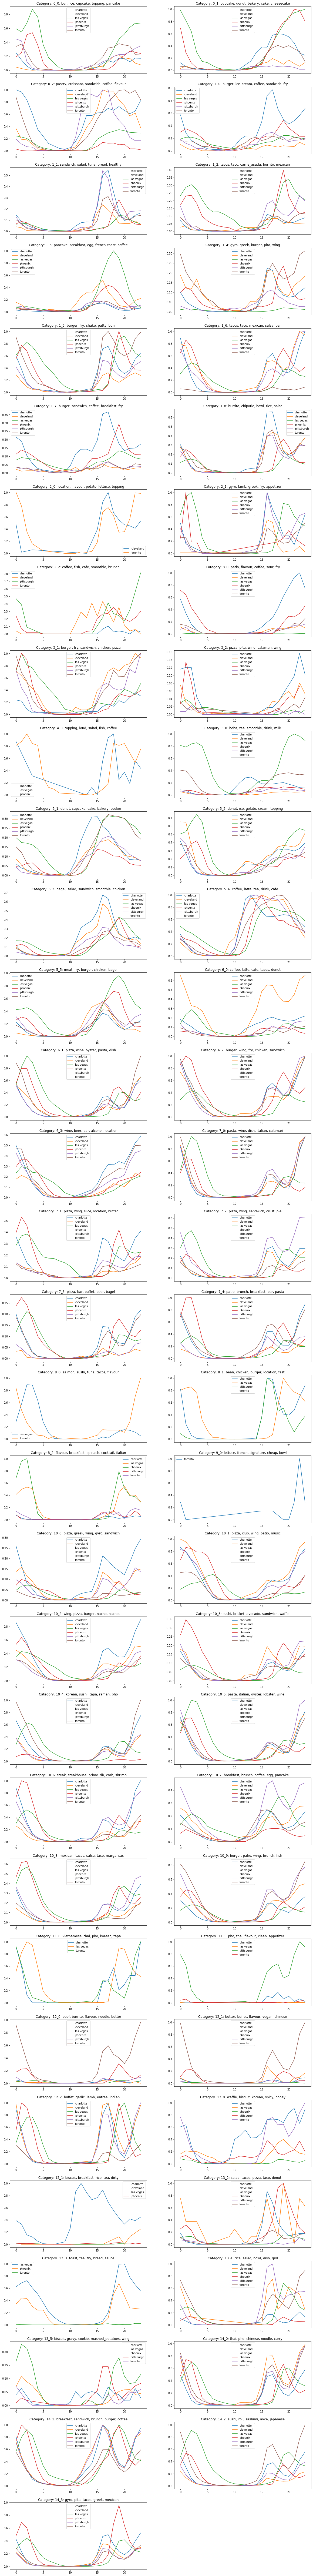

In [12]:
category = df_group['category'].unique()

fig = plt.figure(figsize=(20, 180))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
i = 1
for c in category:
    data_cat = df_group[df_group['category']==c]
    sub_category = data_cat['sub_category'].unique()
    
    for sub in sub_category:
        data = data_cat[data_cat['sub_category']==sub]
        
        top_words = df_top_words[df_top_words['sub_category']==sub]['most frequent words'].values[0]
        top_words = [str(v).strip() for v in top_words.split(',')][:5]
        top_words = ', '.join(top_words)
        
        ax = fig.add_subplot(33, 2, i)
        ax.set_title('Category: '+sub+ ': '+top_words)
        for city in data['city'].unique(): 
            data_sub = data[data['city']==city]
            ax.plot(data_sub['hour'], data_sub['score'], label=city)
            ax.legend(loc='best')
        i+=1

In [14]:
# Extracting the weekday and weekend 

df_rest['Dayofweek'] = ((pd.DatetimeIndex(df_rest.date_2).dayofweek)).astype(float)
df_rest.loc[df_rest['Dayofweek'] <= 4, 'day'] = 'weekday' 
df_rest.loc[df_rest['Dayofweek'] >= 5, 'day'] = 'weekend' 
df_rest

row_id             business_id               name  \
0             0  vjTVxnsQEZ34XjYNS-XUpA  wetzel's pretzels   
1             0  vjTVxnsQEZ34XjYNS-XUpA  wetzel's pretzels   
2             0  vjTVxnsQEZ34XjYNS-XUpA  wetzel's pretzels   
3             0  vjTVxnsQEZ34XjYNS-XUpA  wetzel's pretzels   
4             0  vjTVxnsQEZ34XjYNS-XUpA  wetzel's pretzels   
...         ...                     ...                ...   
7923943   30022  hskVqZCPqy-omm9CHi44xQ           domino's   
7923944   30022  hskVqZCPqy-omm9CHi44xQ           domino's   
7923945   30022  hskVqZCPqy-omm9CHi44xQ           domino's   
7923946   30022  hskVqZCPqy-omm9CHi44xQ           domino's   
7923947   30022  hskVqZCPqy-omm9CHi44xQ           domino's   

                                                categories  \
0         food, pretzels, bakeries, fast food, restaurants   
1         food, pretzels, bakeries, fast food, restaurants   
2         food, pretzels, bakeries, fast food, restaurants   
3         food, pretzels, bakeries, fast food, restaurants   
4         food, pretzels, bakeries, fast food, restaurants   
...                                                    ...   
7923943  restaurants, pizza, sandwiches, fast food, chi...   
7923944  restaurants, pizza, sandwiches, fast food, chi...   
7923945  restaurants, pizza, sandwiches, fast food, chi...   
7923946  restaurants, pizza, sandwiches, fast food, chi...   
7923947  restaurants, pizza, sandwiches, fast food, chi...   

        attributes.RestaurantsPriceRange2  \
0                                       1   
1                                       1   
2                                       1   
3                                       1   
4                                       1   
...                                   ...   
7923943                                 1   
7923944                                 1   
7923945                                 1   
7923946                                 1   
7923947                                 1   

                                       attributes.Ambience  review_count  \
0        {'romantic': False, 'intimate': False, 'touris...            10   
1        {'romantic': False, 'intimate': False, 'touris...            10   
2        {'romantic': False, 'intimate': False, 'touris...            10   
3        {'romantic': False, 'intimate': False, 'touris...            10   
4        {'romantic': False, 'intimate': False, 'touris...            10   
...                                                    ...           ...   
7923943  {'touristy': False, 'hipster': False, 'romanti...            16   
7923944  {'touristy': False, 'hipster': False, 'romanti...            16   
7923945  {'touristy': False, 'hipster': False, 'romanti...            16   
7923946  {'touristy': False, 'hipster': False, 'romanti...            16   
7923947  {'touristy': False, 'hipster': False, 'romanti...            16   

                              address postal_code       city state  \
0        4550 East Cactus Rd, #KSFC-4       85032    phoenix    AZ   
1        4550 East Cactus Rd, #KSFC-4       85032    phoenix    AZ   
2        4550 East Cactus Rd, #KSFC-4       85032    phoenix    AZ   
3        4550 East Cactus Rd, #KSFC-4       85032    phoenix    AZ   
4        4550 East Cactus Rd, #KSFC-4       85032    phoenix    AZ   
...                               ...         ...        ...   ...   
7923943         6420 Rea Rd, Suite B1       28226  charlotte    NC   
7923944         6420 Rea Rd, Suite B1       28226  charlotte    NC   
7923945         6420 Rea Rd, Suite B1       28226  charlotte    NC   
7923946         6420 Rea Rd, Suite B1       28226  charlotte    NC   
7923947         6420 Rea Rd, Suite B1       28226  charlotte    NC   

          longitude   latitude  \
0       -111.983533  33.602822   
1       -111.983533  33.602822   
2       -111.983533  33.602822   
3       -111.983533  33.602822   
4       -111.983533  33.602822   
...             ... 

In [15]:
# Grouping the  data based on 'weekday' & 'weekend'

df_group1 = df_rest.groupby(['category', 'sub_category', 'city', 'hour','day']).agg({'row_id': 'count'}).reset_index()

df_group1 = df_group1.rename(columns={'row_id': 'count'})

df_group1['score'] = df_group1.groupby(['category', 'city','day'])['count'].transform(lambda x: (x - x.min()) / (x.max()- x.min()))
df_group1

category sub_category       city  hour      day  count     score
0           0.0          0_0  charlotte     0  weekday     79  0.274648
1           0.0          0_0  charlotte     0  weekend     45  0.208531
2           0.0          0_0  charlotte     1  weekday     40  0.137324
3           0.0          0_0  charlotte     1  weekend     33  0.151659
4           0.0          0_0  charlotte     2  weekday     14  0.045775
...         ...          ...        ...   ...      ...    ...       ...
14449      14.0         14_3    toronto    21  weekend    783  0.164511
14450      14.0         14_3    toronto    22  weekday   2233  0.246890
14451      14.0         14_3    toronto    22  weekend   1239  0.261183
14452      14.0         14_3    toronto    23  weekday   3029  0.335295
14453      14.0         14_3    toronto    23  weekend   1436  0.302947

[14454 rows x 7 columns]

In [16]:
# Filtering out and creating seperate datasets

dfweekday= df_group1[df_group1['day'] =='weekday'] 
dfweekday

dfweekend= df_group1[df_group1['day'] =='weekend'] 
dfweekend

category sub_category       city  hour      day  count     score
1           0.0          0_0  charlotte     0  weekend     45  0.208531
3           0.0          0_0  charlotte     1  weekend     33  0.151659
5           0.0          0_0  charlotte     2  weekend     16  0.071090
7           0.0          0_0  charlotte     3  weekend      5  0.018957
9           0.0          0_0  charlotte     4  weekend      1  0.000000
...         ...          ...        ...   ...      ...    ...       ...
14445      14.0         14_3    toronto    19  weekend    705  0.147975
14447      14.0         14_3    toronto    20  weekend    656  0.137587
14449      14.0         14_3    toronto    21  weekend    783  0.164511
14451      14.0         14_3    toronto    22  weekend   1239  0.261183
14453      14.0         14_3    toronto    23  weekend   1436  0.302947

[7102 rows x 7 columns]

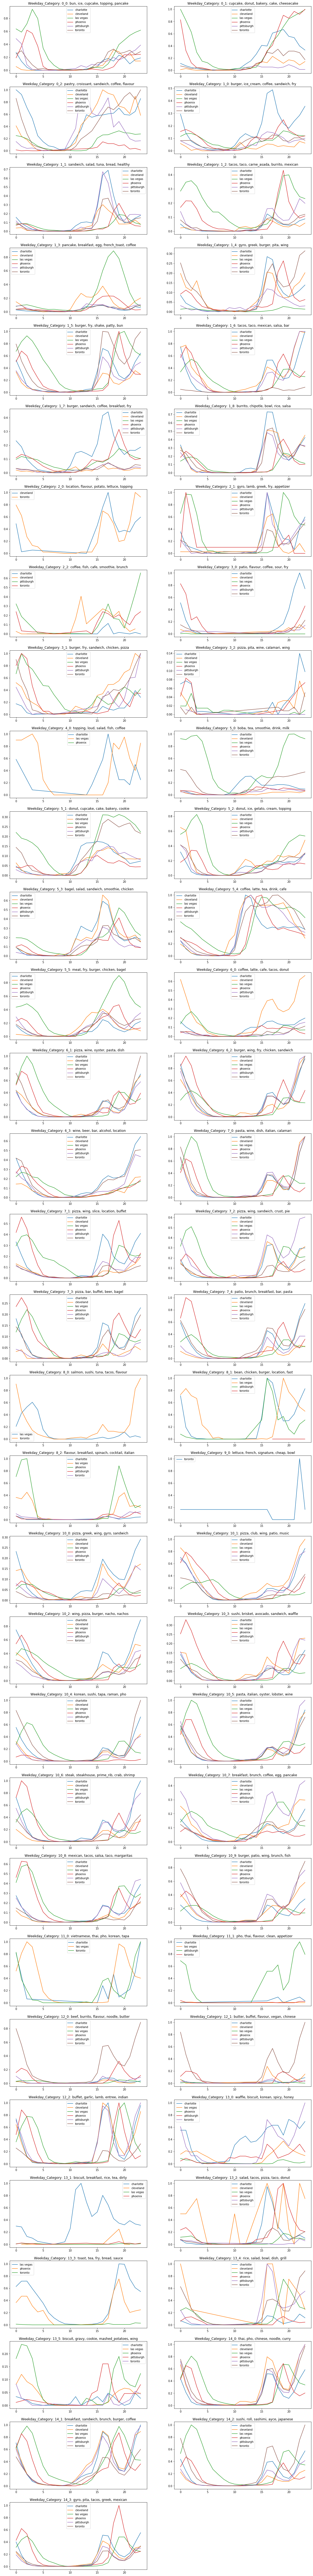

In [17]:
# Plotting weekday 

category = df_group['category'].unique()

fig = plt.figure(figsize=(20, 180))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
i = 1
for c in category:
    data_cat = dfweekday[dfweekday['category']==c]
    sub_category = data_cat['sub_category'].unique()
    
    for sub in sub_category:
        data = data_cat[data_cat['sub_category']==sub]
        
        top_words = df_top_words[df_top_words['sub_category']==sub]['most frequent words'].values[0]
        top_words = [str(v).strip() for v in top_words.split(',')][:5]
        top_words = ', '.join(top_words)
        
        ax = fig.add_subplot(33, 2, i)
        ax.set_title('Weekday_''Category: '+sub+ ': '+top_words)
        for city in data['city'].unique(): 
            data_sub = data[data['city']==city]
            ax.plot(data_sub['hour'], data_sub['score'], label=city)
            ax.legend(loc='best')
            
        i+=1

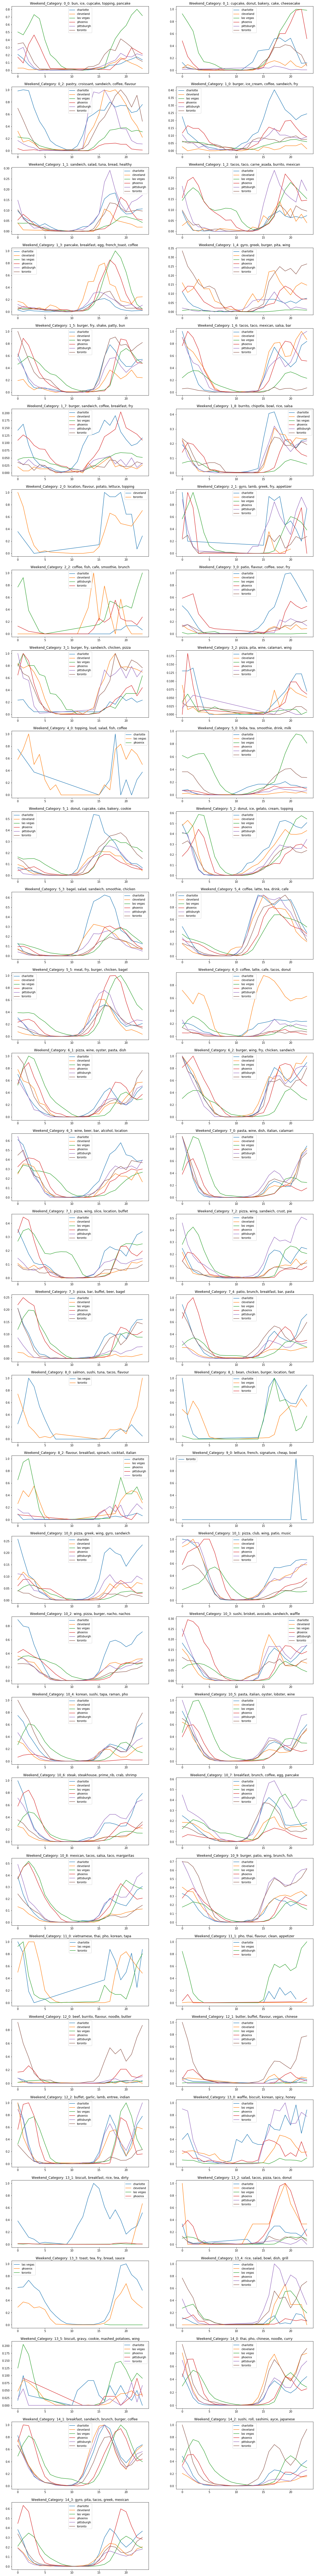

In [18]:
# Plotting weekend

category = df_group['category'].unique()

fig = plt.figure(figsize=(20, 180))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
i = 1
for c in category:
    data_cat = dfweekend[dfweekend['category']==c]
    sub_category = data_cat['sub_category'].unique()
    
    for sub in sub_category:
        data = data_cat[data_cat['sub_category']==sub]
        
        top_words = df_top_words[df_top_words['sub_category']==sub]['most frequent words'].values[0]
        top_words = [str(v).strip() for v in top_words.split(',')][:5]
        top_words = ', '.join(top_words)
        
        ax = fig.add_subplot(33, 2, i)
        ax.set_title('Weekend_'+'Category: '+sub+ ': '+top_words)
        for city in data['city'].unique(): 
            data_sub = data[data['city']==city]
            ax.plot(data_sub['hour'], data_sub['score'], label=city)
            ax.legend(loc='best')
        i+=1